In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.style.use('fivethirtyeight')

In [12]:
regular_season_df.columns

Index(['SEASON', 'DATE', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_PTS', 'AWAY_PTS',
       'HOME_FG', 'AWAY_FG', 'HOME_FGA', 'AWAY_FGA', 'HOME_FG%', 'AWAY_FG%',
       'HOME_3PM', 'AWAY_3PM', 'HOME_3PA', 'AWAY_3PA', 'HOME_3P%', 'AWAY_3P%',
       'HOME_FT', 'AWAY_FT', 'HOME_FTA', 'AWAY_FTA', 'HOME_FT%', 'AWAY_FT%',
       'HOME_ORB', 'AWAY_ORB', 'HOME_DRB', 'AWAY_DRB', 'HOME_TRB', 'AWAY_TRB',
       'HOME_AST', 'AWAY_AST', 'HOME_STL', 'AWAY_STL', 'HOME_BLK', 'AWAY_BLK',
       'HOME_TOV', 'AWAY_TOV', 'HOME_PF', 'AWAY_PF', 'HOME_TS%', 'AWAY_TS%',
       'HOME_EFG%', 'AWAY_EFG%', 'HOME_3PAR', 'AWAY_3PAR', 'HOME_FTR',
       'AWAY_FTR', 'HOME_ORB%', 'AWAY_ORB%', 'HOME_DRB%', 'AWAY_DRB%',
       'HOME_TRB%', 'AWAY_TRB%', 'HOME_AST%', 'AWAY_AST%', 'HOME_STL%',
       'AWAY_STL%', 'HOME_BLK%', 'AWAY_BLK%', 'HOME_TOV%', 'AWAY_TOV%',
       'HOME_ORTG', 'AWAY_ORTG', 'HOME_DRTG', 'AWAY_DRTG', 'HOME_GAME_NUMBER',
       'HOME_REST', 'AWAY_GAME_NUMBER', 'AWAY_REST', 'GAME_TYPE'],
      dtype='object')

In [3]:
games_df = pd.read_csv('data/game/bbref_game_with_game_type.csv')
regular_season_df = games_df[(games_df['GAME_TYPE'] == 'regular_season') & (games_df['SEASON'] != '2019-2020')]


season_means_dict = {}
for team_file in os.listdir('data/team/box_regular_season_mean'):
    team_df = pd.read_csv(f'data/team/box_regular_season_mean/{team_file}')
    season_means_dict[team_file[:-4]] = team_df

In [26]:
games_path = 'data/game/bbref_game_with_game_type.csv'
games_df = pd.read_csv(games_path)

rest_simplifier = {
 '2in2': '2in2',
 '2in3': '2in3',
 '2in4': '1in3',
 '2in5+': '1in3',
 '3in4_1in2': '2in3',
 '3in4_2in2': '2in2',
 '4in5': '2in2',
}

games_df['AWAY_REST'].apply(rest_simplifier)
games_df['HOME_REST'].apply(rest_simplifier)

games_df.to_csv(games_path)

AttributeError: '2in2' is not a valid function for 'Series' object

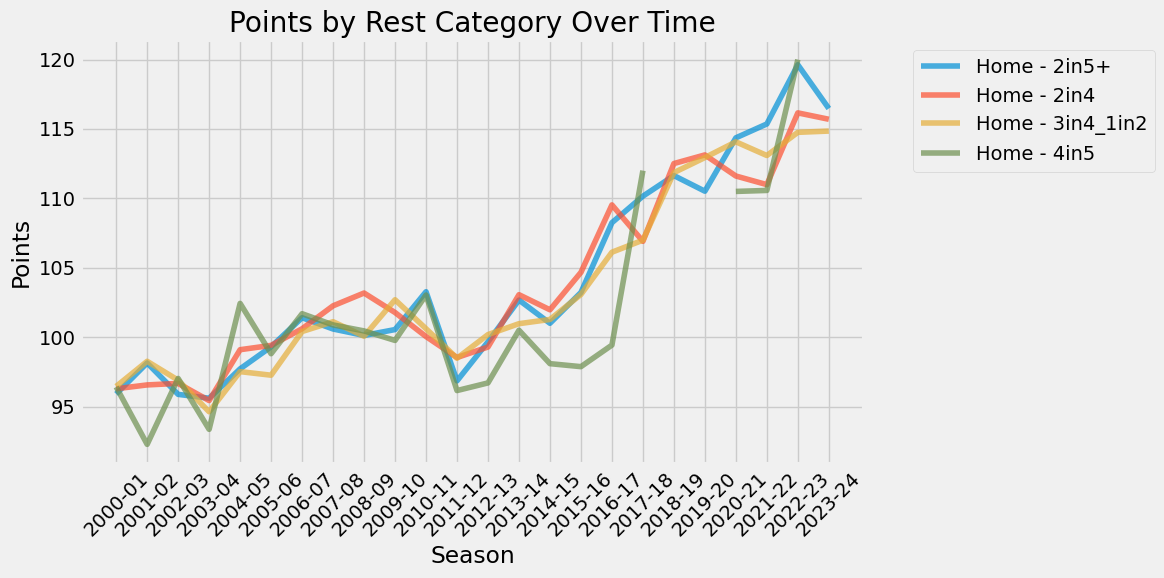

In [24]:
# Create rest category bins
# rest_categories = ['2in2', '2in3', '2in4', '2in5+', '3in4_1in2', '3in4_2in2', '4in5']
rest_categories = ['2in5+', '2in4', '3in4_1in2', '4in5']

# Get unique seasons
seasons = sorted(regular_season_df['SEASON'].unique())

plt.figure(figsize=(12,6))

# Calculate and plot means for each season
for is_home in [True]:
    # Create lists to store means for each rest category
    rest_means = {cat: [] for cat in rest_categories}
    
    # Calculate means for each season
    for season in seasons:
        season_df = regular_season_df[regular_season_df['SEASON'] == season]
        
        # Get means for each rest category
        for rest in rest_categories:
            if is_home:
                mean = season_df[season_df['HOME_REST'] == rest]['HOME_PTS'].mean()
            else:
                mean = season_df[season_df['AWAY_REST'] == rest]['AWAY_PTS'].mean()
            rest_means[rest].append(mean)
    
    # Plot lines for each rest category
    for rest in rest_categories:
        label = f'Home - {rest}' if is_home else f'Away - {rest}'
        plt.plot(seasons, rest_means[rest], label=label, alpha=0.7)

plt.title('Points by Rest Category Over Time')
plt.xlabel('Season') 
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
